In [ ]:
import keras
import json
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn as nil
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K 

import tensorflow as tf


## First glance at the data

In [2]:
HOME_DIR = 'Lung'
DATA_DIR = HOME_DIR

In [ ]:
import os
from collections import Counter

directory = '/media/data/uv/imagesTr/'

shape_images = []

files = [file for file in os.listdir(directory) if file.endswith(".nii.gz")]

print(len(files))

for file in files:
    filename = os.path.join(directory, file)
    shape_images.append(nib.load(filename).get_fdata().shape)

shape_counts = Counter(shape_images)


There are 52 various depth shapes in the dataset

In [ ]:
len(shape_counts)
shape_counts

In [158]:
import os
example_pic = os.path.join('/media/data/uv/imagesTr/lung_006.nii.gz')
example_label = os.path.join('/media/data/uv/labelsTr/lung_006.nii.gz')

In [159]:
img = nib.load(example_pic)
type(img)

nibabel.nifti1.Nifti1Image

In [160]:
img_data = img.get_fdata()
type(img_data)

numpy.ndarray

In [161]:
img_data.shape

(512, 512, 567)

That is how the Lung MRI data for this task look like (slice across the 2nd dimensioon taken)

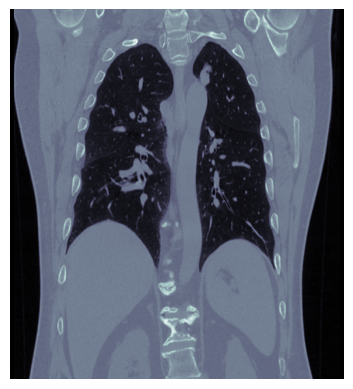

In [162]:
plt.imshow(ndi.rotate(img_data[:,200, :], 90), cmap='bone')
plt.axis('off')
plt.show()

In [163]:
label = nib.load(example_label)
type(label)

nibabel.nifti1.Nifti1Image

In [164]:
label_data = label.get_fdata()
type(label_data)

numpy.ndarray

In [165]:
label.shape

(512, 512, 567)

### Visualizing labels

White spot is cancerous area (slice across the 2nd dimension taken)

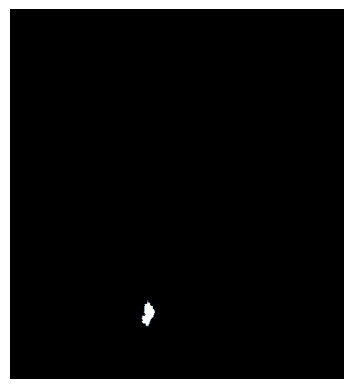

In [166]:
plt.imshow(ndi.rotate(label_data[:,200, :], 270), cmap='bone')
plt.axis('off')
plt.show()

### Lokalizing cancer on an MRI image

### TBD: add 3d gif of the lung MRI

We see that cancer mostly localizes in one spot
that is why it is preferable to process the data keeping its volume

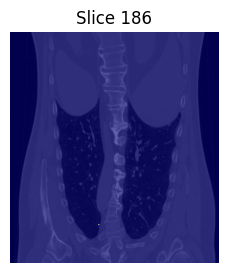

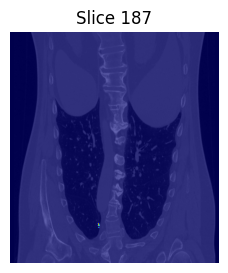

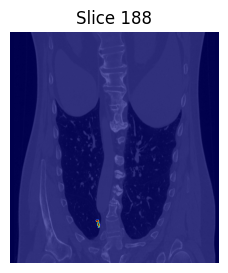

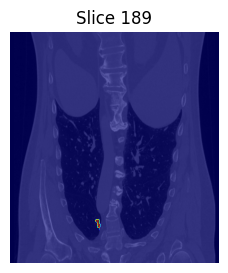

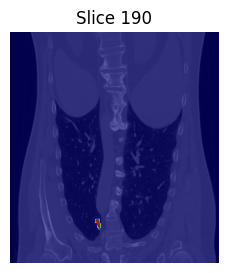

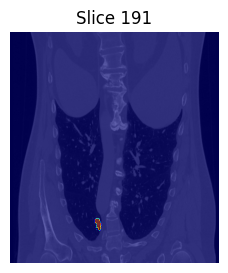

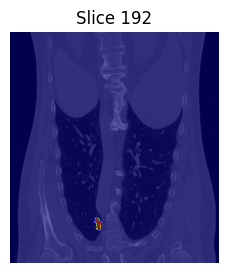

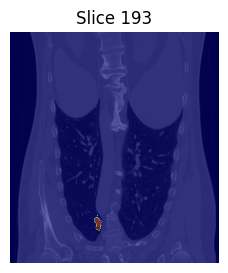

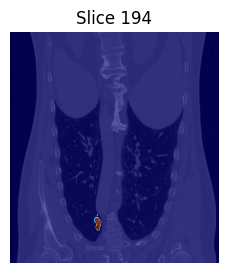

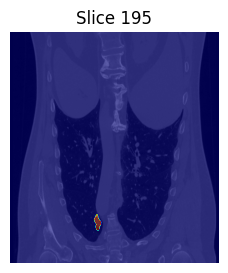

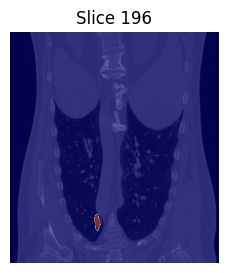

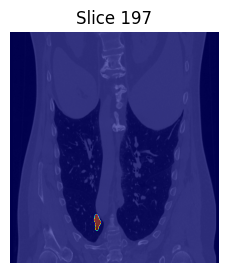

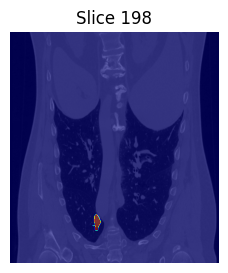

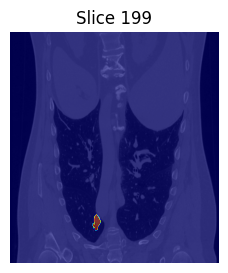

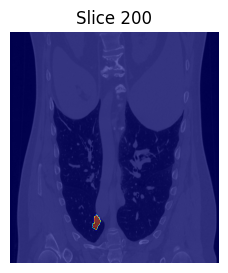

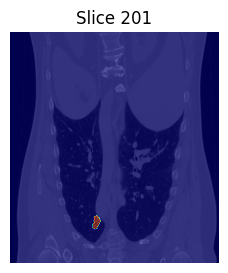

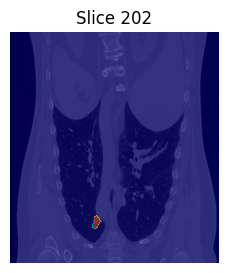

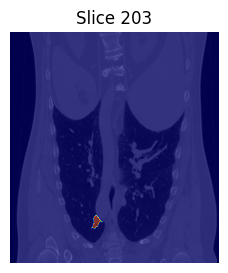

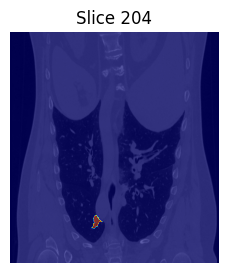

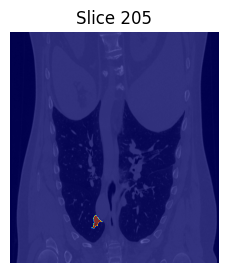

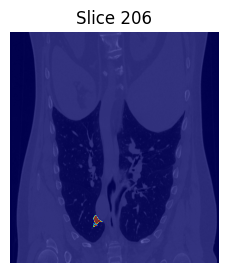

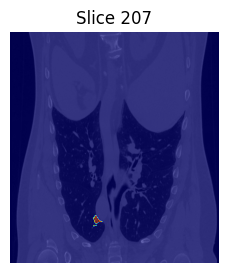

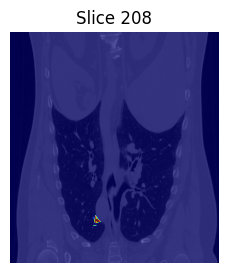

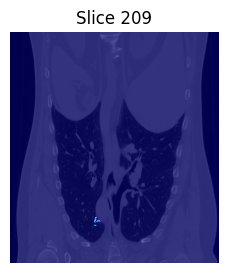

In [167]:
for i in range(186, 210):
    if np.any(label_data[:, i, :] == 1):
        plt.figure(figsize=(3, 3))
        plt.imshow(ndi.rotate(img_data[:,i,:], 270), cmap='gray')
        plt.imshow(ndi.rotate(label_data[:,i, :], 270), cmap='jet', alpha=0.6)
        plt.title(f'Slice {i}')
        plt.axis('off')
    
        plt.show()


## Standartize the data

### Get subvolumes

#### Subvolumes are required due to the limited computational power

Make sure to obtain subvolumes containing at least 1 % of cancerous areas
as the data is highly imbalanced

In [168]:
img_data.shape[1]

512

In [169]:
def get_subvolume(image, label, orig_z, orig_x=512, orig_y=512,
                   output_x=160, output_y=160, output_z=16,
                   num_classes=2, max_tries=500,
                   background_threshold=0.99):

    X = None
    y = None

    tries = 0

    #print(image.shape)
    #print(label.shape)

    while tries < max_tries:
        start_x = np.random.randint(0, orig_x - output_x + 1)
        start_y = np.random.randint(0, orig_y - output_y + 1)
        start_z = np.random.randint(0, orig_z - output_z + 1)

        y = label[start_x: start_x+ output_x,
                start_y: start_y+ output_y,
                start_z: start_z+ output_z
                ]
        
        y = keras.utils.to_categorical(y, num_classes)
        b_ratio = np.sum(y[..., 0]) / (output_x * output_y * output_z)

        tries += 1

        if b_ratio < background_threshold:

            X = np.copy(image[start_x: start_x + output_x,
                                    start_y: start_y + output_y,
                                    start_z: start_z + output_z])
            #print(b_ratio)

            y = np.moveaxis(y, -1, 0)[1:, :, :, :]

            return X, y

  
    print(f"Tried {tries} times to find a sub-volume. Giving up...")
    return X,y

X,y = get_subvolume(image=img_data, label=label_data, orig_z=img_data.shape[2])

Obtained size of subvolumes 

In [170]:
print(X.shape)
print(y.shape)

(160, 160, 16)
(1, 160, 160, 16)


### Checking subvolumes

Let's look at some of the obtained subvolumes

Load two examples (slice of the subvolumes is shown)

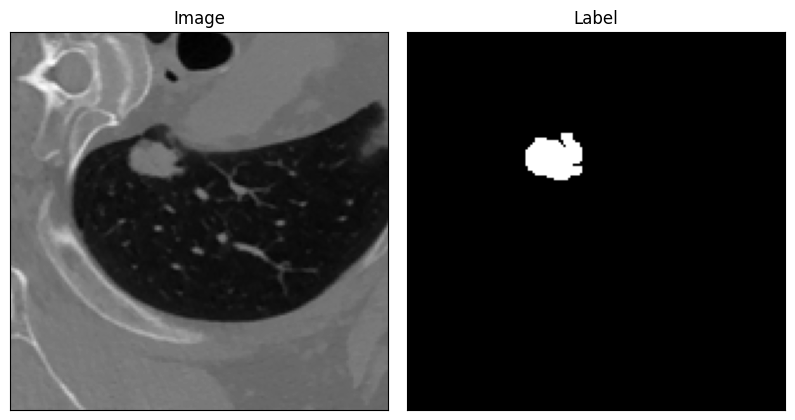

In [171]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_patch(X, y):
    fig, ax = plt.subplots(1, 2, figsize=[10, 10], squeeze=False)

    ax[0][0].imshow(X[:, :, X.shape[2] // 2], cmap='gray')
    ax[0][0].set_title('Image')
    ax[0][0].set_yticks([])
    ax[0][0].set_xticks([])
    
    ax[0][1].imshow(y[:, :, y.shape[2] // 2], cmap='gray')
    ax[0][1].set_title('Label')
    ax[0][1].set_xticks([])
    ax[0][1].set_yticks([])
    
    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()


X, y = get_subvolume(image=img_data, label=label_data, orig_z=img_data.shape[2])
visualize_patch(X, y[0])


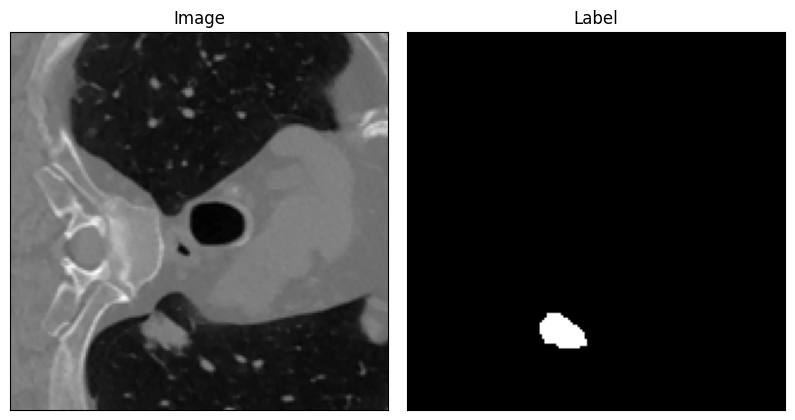

In [190]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_patch(X, y):
    fig, ax = plt.subplots(1, 2, figsize=[10, 10], squeeze=False)

    ax[0][0].imshow(X[:, :, X.shape[2] // 2], cmap='gray')
    ax[0][0].set_title('Image')
    ax[0][0].set_yticks([])
    ax[0][0].set_xticks([])
    
    ax[0][1].imshow(y[:, :, y.shape[2] // 2], cmap='gray')
    ax[0][1].set_title('Label')
    ax[0][1].set_xticks([])
    ax[0][1].set_yticks([])
    
    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()


X, y = get_subvolume(image=img_data, label=label_data, orig_z=img_data.shape[2])
visualize_patch(X, y[0])


### Standardize the values across a depth dimension to have a mean of zero and standard deviation of 1

In [3]:
def standartize(image):

    standartized_img = np.zeros((image.shape))

    for z in range(image.shape[2]):
        img_slice = image[:,:,z]

        centered = img_slice - np.mean(img_slice)

        if np.std(centered) != 0:
            centered = centered / np.std(centered)

        standartized_img[:,:,z] = centered
    
    return standartized_img

### Check that standartization didn't affect the output

In [ ]:
X,y_slice = get_subvolume(img_data, label_data, orig_z=img_data.shape[2])
X_normalized = standartize(X)
visualize_patch(X_normalized,y_slice[0])

## Initialize evaluation metric and loss

In [4]:
def dice_coefficient(y_true, y_pred, axis=(0, 1, 2), epsilon=0.00001):

    dice_coef = (2 * K.sum(y_pred * y_true, axis = axis) + epsilon) / (K.sum(y_pred, axis = axis) + K.sum(y_true, axis = axis) + epsilon)

    return dice_coef

In [5]:
def soft_dice_loss(y_true, y_pred, axis=(0, 1, 2), epsilon=0.00001):

    dice_loss = 1 - K.mean((2 * K.sum(y_pred * y_true, axis = axis) + epsilon) / (K.sum((y_pred**2), axis) + K.sum((y_true**2), axis) + epsilon))

    return dice_loss

## Initialize the 3D U-Net architecture

In [ ]:
from tensorflow.keras.layers import Conv3D, Activation, Conv3DTranspose, BatchNormalization, MaxPooling3D, Add
from tensorflow.keras import Input, Model
from keras.optimizers import Adam

Define a convolutional block

In [7]:
def conv_block(x, filters, kernel_size=(3,3,3), padding='same', activation='relu'):

    x = Conv3D(filters=filters, kernel_size=kernel_size, padding=padding)(x)
    x = Activation(activation)(x)
    x = BatchNormalization()(x)

    return x

Define an upsampling block

In [8]:
def upconv_block(x, skip, filters, kernel_size=(2,2,2), strides = (2,2,2), padding='same'):

    x = Conv3DTranspose(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding)(x)
    x = Add()([x, skip])

    return x

Since we take subvolumes, the input shape is 16 * 160 * 16 * 1 channel

In [9]:
input_shape=(16,160,160,1)

inputs = Input(input_shape)

Build a U-Net out of obtained blocks

In [10]:
c1 = conv_block(inputs, 32)
c2 = conv_block(c1, 64)
p1 = MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='same')(c2)

c3 = conv_block(p1, 64)
c4 = conv_block(c3, 128)
p2 = MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='same')(c4)

c5 = conv_block(p2, 128)
c6 = conv_block(c5, 256)
p3 = MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='same')(c6)

c7 = conv_block(p3, 256)
c8 = conv_block(c7, 512)

up1 = upconv_block(c8, c6, 256)
c9 = conv_block(up1, 256)
c10 = conv_block(c9, 256)

up2 = upconv_block(c10, c4, 128)
c11 = conv_block(up2, 128)
c12 = conv_block(c11, 128)

up3 = upconv_block(c12, c2, 64)
c13 = conv_block(up3, 64)
c14 = conv_block(c13, 64)

c15 = Conv3D(1, kernel_size = (3, 3, 3), padding = 'same', activation = 'sigmoid')(c14)

model = Model(inputs=inputs, outputs=c15)

model.summary()

2024-08-09 07:07:18.766314: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-09 07:07:18.801842: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-09 07:07:18.804065: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 16, 160,   │          0 │ -                 │
│ (InputLayer)        │ 160, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 16, 160,   │        896 │ input_layer[0][0] │
│                     │ 160, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 16, 160,   │          0 │ conv3d[0][0]      │
│ (Activation)        │ 160, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16, 160,   │        128 │ activation[0][0]  │
│ (BatchNormalizatio… │ 160, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 16, 160,   │     55,360 │ batch_normalizat… │
│                     │ 160, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 16, 160,   │          0 │ conv3d_1[0][0]    │
│ (Activation)        │ 160, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 160,   │        256 │ activation_1[0][… │
│ (BatchNormalizatio… │ 160, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 8, 80, 80, │          0 │ batch_normalizat… │
│ (MaxPooling3D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 8, 80, 80, │    110,656 │ max_pooling3d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 8, 80, 80, │          0 │ conv3d_2[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 80, 80, │        256 │ activation_2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 8, 80, 80, │    221,312 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 8, 80, 80, │          0 │ conv3d_3[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 80, 80, │        512 │ activation_3[0][… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 4, 40, 40, │          0 │ batch_normalizat… │
│ (MaxPooling3D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 4, 40, 40, │    442,496 │ max_pooling3d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 4, 40, 40, │          0 │ conv3d_4[0][0]  

 Total params: 13,058,433 (49.81 MB)

 Trainable params: 13,053,761 (49.80 MB)

 Non-trainable params: 4,672 (18.25 KB)

Iterate over directory

Extract all filenames

Get data for all filenames as images

In [ ]:
import os
list_images = []
list_labels = []

directory = 'imagesTr/'

files = [file for file in os.listdir(directory) if file.endswith(".nii.gz")]
files.sort()

for file in files:
    filename = os.path.join(directory, file)
    print(filename)
    list_images.append(nib.load(filename).get_fdata())


In [ ]:
X_train = list_images[:50]
X_test = list_images[50:]

y_train = list_labels[:50]
y_test = list_labels[50:]

The data was too impossible to obtain in one row, so multiple chunks were generated

In [ ]:
def save_data_npz(X, y, filename):
    np.savez_compressed(filename, X=X, y=y)
    print(f'Data saved to {filename}')

def generate_data(X_train, y_train, num_slices=10000, chunk_size=1000, filename_prefix='train_data'):
    counter = 0
    X_chunk = []
    y_chunk = []

    while counter < num_slices:
        for i, image in enumerate(X_train):
            if counter >= num_slices:
                break

            X_slice, y_slice = get_subvolume(X_train[i], y_train[i], orig_z=X_train[i].shape[2])
            if X_slice is not None:
                X_chunk.append(X_slice)
                y_chunk.append(y_slice)
                counter += 1
                print('Current number of data points:', counter)

              
                if len(X_chunk) >= chunk_size:
                    save_data_npz(np.array(X_chunk), np.array(y_chunk), f'{filename_prefix}_chunk_{counter // chunk_size}.npz')
                    X_chunk = []
                    y_chunk = []

   
    if X_chunk:
        save_data_npz(np.array(X_chunk), np.array(y_chunk), f'{filename_prefix}_chunk_{counter // chunk_size + 1}.npz')


generate_data(X_train, y_train)


Load full dataset

In [11]:
import h5py

h5_file_path = '/media/data/uv/standardized_train_data.h5'

with h5py.File(h5_file_path, 'r') as f:
    X = f['X_standardized'][:]
    y = f['y'][:]

    print(f'X shape: {X.shape}')
    print(f'y shape: {y.shape}')


X shape: (10074, 160, 160, 16)
y shape: (10074, 1, 160, 160, 16)


Input requires a channel dimension

In [13]:
X = np.expand_dims(X, axis=1)
X.shape

(10074, 1, 160, 160, 16)

In [14]:
print(f'y shape: {y.shape}')

y shape: (10074, 1, 160, 160, 16)


Convert the data according to the input shape

In [15]:
input_shape=(16,160,160,1)

# Convert from (16,160,160,1) to (1,160,160,16)
X = np.transpose(X, (0, 4, 2, 3, 1))
X.shape

y = np.transpose(y, (0, 4, 2, 3, 1))
y.shape

(10074, 16, 160, 160, 1)

In [29]:
epochs = 120
batch_size = 3

Split the dataset to train and validation parts

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
X_train.shape

(8059, 16, 160, 160, 1)

In [19]:
y_train.shape

(8059, 16, 160, 160, 1)

Set a data generator which divides the data to batches

In [ ]:
def data_generator(X, y, batch_size):
    while True:
        
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        
        for start in range(0, len(X), batch_size):
            end = min(start + batch_size, len(X))
            batch_indices = indices[start:end]
            yield X[batch_indices], y[batch_indices]

In [21]:
model.compile(optimizer=Adam(learning_rate = 0.001), loss=soft_dice_loss, metrics=[dice_coefficient])

In [22]:
train_gen = data_generator(X_train, y_train, batch_size)
val_gen = data_generator(X_val, y_val, batch_size)

Set the number of steps per epoch

In [23]:
steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_val) // batch_size

In [24]:
steps_per_epoch

2686

In [30]:
import os
from tensorflow.keras.models import load_model

checkpoint_dir = '/media/data/uv/checkpoints_clas/'

latest_checkpoint = max([checkpoint_dir + f for f in os.listdir(checkpoint_dir)], key=os.path.getctime)

def dice_coefficient(y_true, y_pred, axis=(0, 1, 2), epsilon=0.00001):
    dice_coef = (2 * K.sum(y_pred * y_true, axis=axis) + epsilon) / (K.sum(y_pred, axis=axis) + K.sum(y_true, axis=axis) + epsilon)
    return dice_coef

def soft_dice_loss(y_true, y_pred, axis=(0, 1, 2), epsilon=0.00001):
    dice_loss = 1 - K.mean((2 * K.sum(y_pred * y_true, axis=axis) + epsilon) / (K.sum((y_pred**2), axis) + K.sum((y_true**2), axis) + epsilon))
    return dice_loss

if latest_checkpoint:
    model = load_model(latest_checkpoint, custom_objects={'soft_dice_loss': soft_dice_loss, 'dice_coefficient': dice_coefficient})
    print(f"Loaded model from checkpoint: {latest_checkpoint}")



Loaded model from checkpoint: /media/data/uv/checkpoints_clas/model_epoch_93.keras


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True  
)

checkpoint = ModelCheckpoint(
    filepath='/media/data/uv/checkpoints_clas/model_epoch_{epoch:02d}.keras',
    save_weights_only=False,
    save_freq='epoch'
)

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              #patience=2, min_lr=0.000001, verbose=1),


history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=epochs,
    initial_epoch=int(latest_checkpoint.split('_')[-1].split('.')[0]),
    verbose=1,
    callbacks=[early_stopping, checkpoint]#, reduce_lr]
)



## Model Evaluation

Load test data in h5 format

In [119]:
import h5py

h5_file_path = 'test_data_standardized.h5'

with h5py.File(h5_file_path, 'r') as f:
    X = f['X'][:]
    y = f['y'][:]

    print(f'X shape: {X.shape}')
    print(f'y shape: {y.shape}')

X shape: (200, 160, 160, 16)
y shape: (200, 1, 160, 160, 16)


Tranform the test data according to how the the training data is transformed

In [120]:
X = np.expand_dims(X, axis=1)
X.shape

(200, 1, 160, 160, 16)

In [121]:
input_shape=(16,160,160,1)

# Convert from (16,160,160,1) to (1,160,160,16)
X = np.transpose(X, (0, 4, 2, 3, 1))
X.shape

y = np.transpose(y, (0, 4, 2, 3, 1))
y.shape

(200, 16, 160, 160, 1)

In [122]:
X.shape

(200, 16, 160, 160, 1)

Load the model from the best checkpoint

In [ ]:
model = load_model('/media/data/uv/checkpoints_clas/model_epoch_98.keras', custom_objects={'soft_dice_loss': soft_dice_loss, 'dice_coefficient': dice_coefficient})
print(f"Loaded model from checkpoint")

Assign the same number of batches and steps

In [124]:
batch_size = 3
test_gen = data_generator(X, y, batch_size)

In [125]:
steps = len(X) // batch_size

In [126]:
print("X shape:", X.shape)
print("y shape:", y.shape)
print("X dtype:", X.dtype)
print("y dtype:", y.dtype)

X shape: (200, 16, 160, 160, 1)
y shape: (200, 16, 160, 160, 1)
X dtype: float64
y dtype: float64


Transform the test data to np.float32

In [127]:
X = X.astype(np.float32)
y = y.astype(np.float32)

In [128]:
print("X shape:", X.shape)
print("y shape:", y.shape)
print("X dtype:", X.dtype)
print("y dtype:", y.dtype)

X shape: (200, 16, 160, 160, 1)
y shape: (200, 16, 160, 160, 1)
X dtype: float32
y dtype: float32


In [129]:
X[0]

array([[[[-0.67186713],
         [-0.6351052 ],
         [-0.6994386 ],
         ...,
         [ 0.71589637],
         [ 0.60561055],
         [ 0.2954316 ]],

        [[-0.75687915],
         [-0.7499863 ],
         [-0.8395935 ],
         ...,
         [ 0.56195575],
         [ 0.4309913 ],
         [ 0.06337181]],

        [[-0.8395935 ],
         [-0.81891495],
         [-0.83040303],
         ...,
         [-0.05610451],
         [-0.23761663],
         [-0.4145335 ]],

        ...,

        [[-1.3037131 ],
         [-1.2393798 ],
         [-1.2324868 ],
         ...,
         [-1.377237  ],
         [-1.377237  ],
         [-1.377237  ]],

        [[-1.2945226 ],
         [-1.2164035 ],
         [-1.3037131 ],
         ...,
         [-1.377237  ],
         [-1.377237  ],
         [-1.377237  ]],

        [[-1.377237  ],
         [-1.2945226 ],
         [-1.3220941 ],
         ...,
         [-1.377237  ],
         [-1.377237  ],
         [-1.377237  ]]],


       [[[-0.8211628 ],


In [304]:
steps = len(X) // batch_size

eval_results = model.evaluate(test_gen, steps=steps)
val_loss, val_dice = eval_results
print(f'Validation soft dice loss: {val_loss:.4f}')
print(f'Validation dice coefficient: {val_dice:.4f}')

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - dice_coefficient: 0.7621 - loss: 0.2041
Validation soft dice loss: 0.1663
Validation dice coefficient: 0.7959


## Visualization of the model performance

Get one example from the test data

In [ ]:
def get_single_example(data_gen):
    for batch_X, batch_y in data_gen:
        return batch_X, batch_y
    return None, None

batch_X, batch_y = get_single_example(test_gen)
sample_X = batch_X[0]
sample_y = batch_y[0]


In [321]:
sample_y.shape

(16, 160, 160, 1)

Get the neccessary shape (+num_samples/batch)

In [ ]:
sample_X_batch = np.expand_dims(sample_X, axis=0)
sample_y_batch = np.expand_dims(sample_y, axis=0)

predictions = model.predict(sample_X_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [323]:
predictions.shape

(1, 16, 160, 160, 1)

## Visualize a patch

(16, 160, 160, 1)


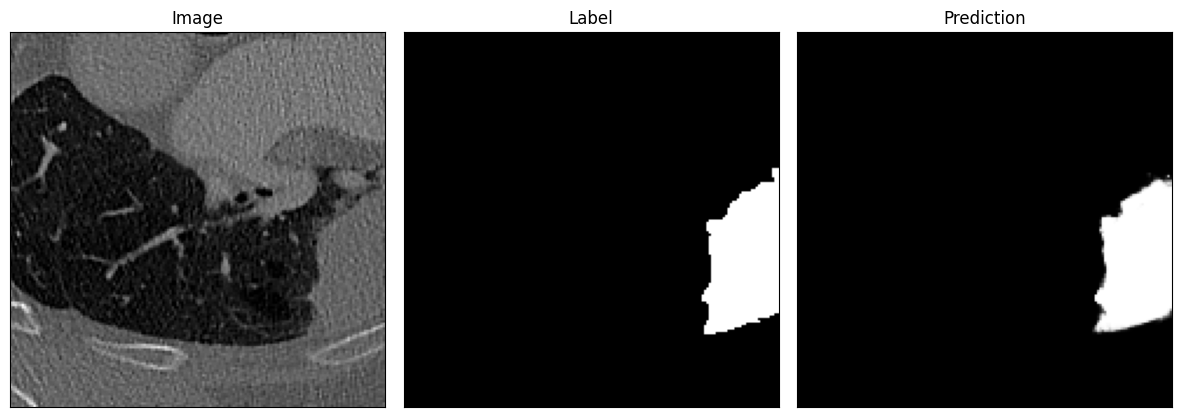

In [ ]:
def visualize_patch(X, y, prediction):

    X = np.transpose(np.squeeze(X), (1, 2, 0))
    y = np.transpose(np.squeeze(y), (1, 2, 0))
    prediction = np.transpose(np.squeeze(prediction), (1, 2, 0))
    
    fig, ax = plt.subplots(1, 3, figsize=[15, 10], squeeze=False)

    ax[0][0].imshow(X[:, :, X.shape[2] // 2], cmap='gray')
    ax[0][0].set_title('Image')
    ax[0][0].set_yticks([])
    ax[0][0].set_xticks([])
    
    ax[0][1].imshow(y[:, :, y.shape[2] // 2], cmap='gray')
    ax[0][1].set_title('Label')
    ax[0][1].set_xticks([])
    ax[0][1].set_yticks([])

        
    ax[0][2].imshow(prediction[:, :, prediction.shape[2] // 2], cmap='gray')
    ax[0][2].set_title('Prediction')
    ax[0][2].set_xticks([])
    ax[0][2].set_yticks([])
    
    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()


predicted_patch = predictions[0]
print(sample_y.shape)

visualize_patch(sample_X, sample_y, predicted_patch)
